**Mobile Net**

link gdrive : https://drive.google.com/drive/folders/1YwwKYx5nVoIPzTuQqHL_8tHS0heYF8A0?usp=sharing

**Loading Library dan konfigurasi**

In [1]:
import os
import numpy as np


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# Paths dataset
train_dir = "/content/drive/MyDrive/Dataset/Dataset/train"
val_dir   = "/content/drive/MyDrive/Dataset/Dataset/val"
test_dir  = "/content/drive/MyDrive/Dataset/Dataset/test"

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# PENTING: Meningkatkan Epoch untuk MobileNet From Scratch
EPOCHS = 20

# Urutan nama kelas sesuai folder
CLASS_NAMES_ORDER = ["bika ambon", "kerak telur", "papeda", "plecing kangkung"]
NUM_CLASSES = len(CLASS_NAMES_ORDER) # Jumlah kelas = 4

print("Kelas:", CLASS_NAMES_ORDER)

Kelas: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


**Mengecek dataset bermasalah**

In [4]:
allowed_ext = [".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"]
root_dirs = [train_dir, val_dir, test_dir]

for root_dir in root_dirs:
    for kelas in os.listdir(root_dir):
        class_path = os.path.join(root_dir, kelas)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            # hapus subfolder di dalam kelas
            if os.path.isdir(fpath):
                print("⚠ Ada subfolder dalam kelas (hapus manual):", fpath)
            else:
                ext = os.path.splitext(fname)[1].lower()
                if ext not in allowed_ext:
                    print("🗑 hapus file non-gambar:", fpath)
                    os.remove(fpath)


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Dataset/Dataset/train'

**Load Dataset**

In [ ]:
def load_data(directory, img_size=(224,224), batch_size=32, shuffle=True):
    """
    Meload dataset gambar dari folder.
    Parameter:
        directory   : path folder (train / val / test)
        img_size    : ukuran target gambar (width,height)
        batch_size  : jumlah gambar per batch
        shuffle     : apakah diacak
    Output:
        tf.data.Dataset yang berisi (image_batch, label_batch)
        label diberikan otomatis berdasarkan nama folder kelas
    """
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',         # label diambil dari nama folder
        label_mode='int',          # integer label (0,1,2,3)
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle
    )
    return dataset

train_ds = load_data(train_dir, IMG_SIZE, BATCH_SIZE, shuffle=True)
val_ds   = load_data(val_dir,   IMG_SIZE, BATCH_SIZE, shuffle=True)
test_ds  = load_data(test_dir,  IMG_SIZE, BATCH_SIZE, shuffle=True)

print("Class names terdeteksi:", train_ds.class_names)

Found 640 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
Class names terdeteksi: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


**Visualisasi Data**

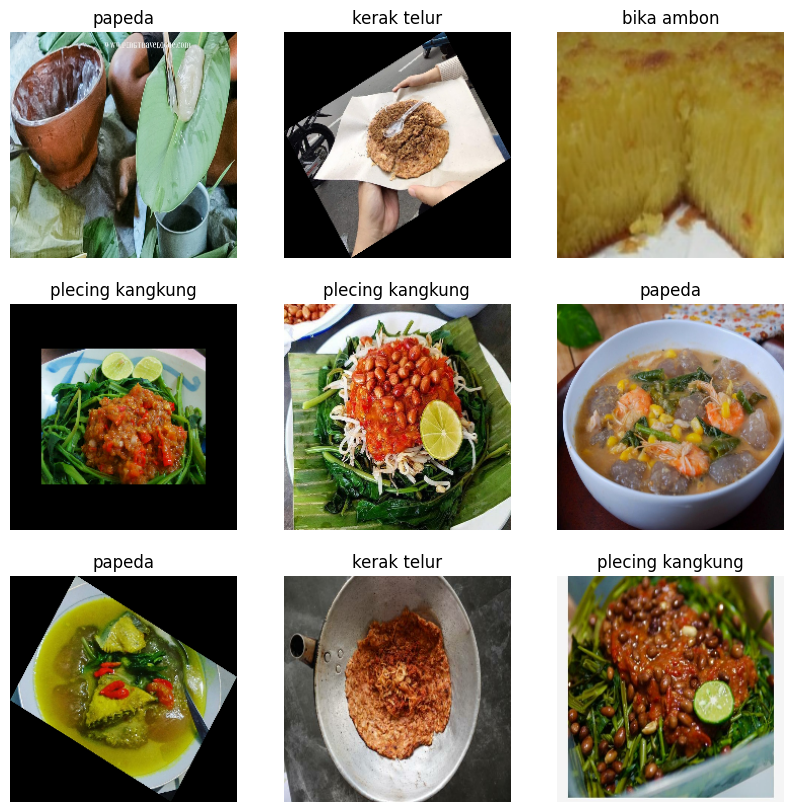

In [ ]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(CLASS_NAMES_ORDER[labels[i]])
        plt.axis('off')

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)


(32, 224, 224, 3)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

**Augmentasi Data**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers

# --- PENTING: Pipeline Augmentasi Agresif ---
# Menerapkan Rescaling dan Augmentasi
data_augmentation = Sequential([
    # Rescaling wajib karena data input (255) harus dinormalisasi (0-1)
    Rescaling(1./255),

    # Tambahan: Random Gaussian Noise untuk melawan overfitting
    layers.GaussianNoise(0.1),

    # Augmentasi Agresif untuk dataset kecil
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),       # Rotasi hingga 20%
    layers.RandomZoom(0.2),          # Zoom hingga 20%
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2), # Geser
    layers.RandomContrast(0.2),      # Penyesuaian kontras acak
], name='data_augmentation')

# Karena Anda menggunakan image_dataset_from_directory dengan label integer (label_mode='int'),
# kita perlu memetakan label ke format one-hot jika menggunakan loss Categorical.
# Namun, kita akan menggunakan SparseCategoricalCrossentropy agar label tetap integer.

def preprocess_data(image, label):
    # Normalisasi sudah dilakukan di layer data_augmentation
    return image, label

# Terapkan pre-processing pada dataset
train_ds = train_ds.map(preprocess_data)
val_ds   = val_ds.map(preprocess_data)
test_ds  = test_ds.map(preprocess_data)

# Optimasi performa data loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

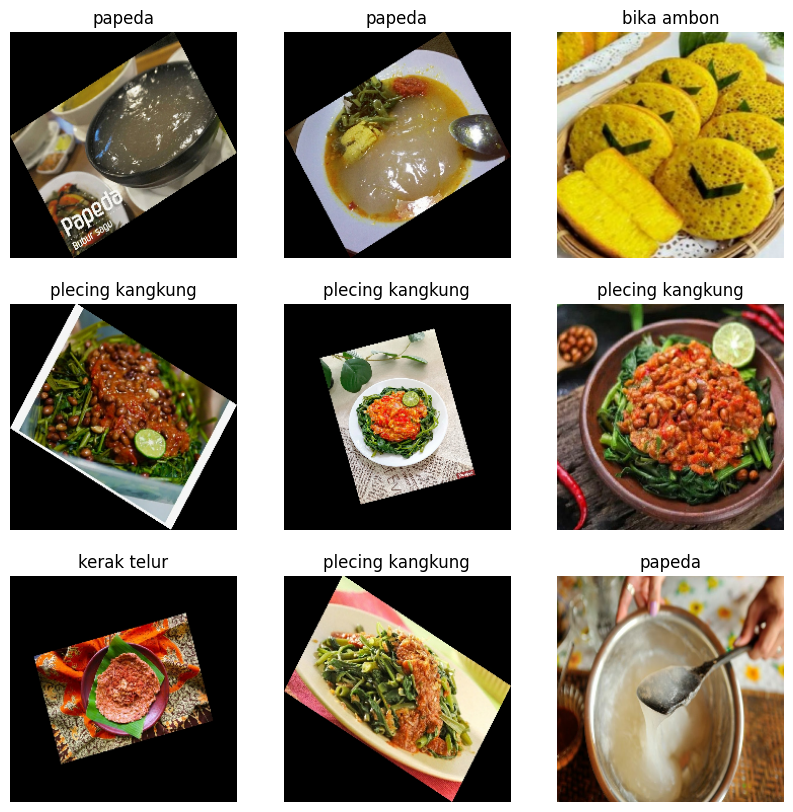

In [ ]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images[i:i+1])
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(CLASS_NAMES_ORDER[labels[i]])
        plt.axis('off')

**MOBILE NET**

In [ ]:
# --- Pembuatan MobileNetV2 Dari Awal dengan Kapasitas Rendah ---
def create_mobilenet_model_from_scratch(input_shape, num_classes, alpha=0.5):
    # MobileNetV2 base model (alpha=0.5)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=None,
        alpha=0.25
    )

    # Classification Head dengan Regularisasi Lebih Kuat
    model = Sequential([
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        # Dense(128, activation='relu'),
        # PENTING: Meningkatkan Dropout untuk Regularisasi yang Lebih Agresif
        Dropout(0.7),                   # Ditingkatkan dari 0.5 menjadi 0.7
        Dense(num_classes, activation='softmax')
    ], name='MobileNetV2_Scratch_Alpha_0.5_Aggressive_Dropout')

    return model

# Pastikan model diinisialisasi ulang dengan fungsi yang dimodifikasi ini:
model = create_mobilenet_model_from_scratch(IMG_SIZE + (3,), NUM_CLASSES, alpha=0.5)
model.summary()

Model: "MobileNetV2_Scratch_Alpha_0.5_Aggressive_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (1, 224, 224, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.25_224            │ (1, 7, 7, 1280)        │       248,768 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (1, 1280)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 1280)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 4)                 │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,892 (991.77 KB)

 Trainable params: 243,236 (950.14 KB)

 Non-trainable params: 10,656 (41.62 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "MobileNetV2_Scratch_Alpha_0.5_Aggressive_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (1, 224, 224, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.25_224            │ (1, 7, 7, 1280)        │       248,768 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (1, 1280)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 1280)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 4)                 │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,892 (991.77 KB)

 Trainable params: 243,236 (950.14 KB)

 Non-trainable params: 10,656 (41.62 KB)

In [ ]:
# --- Kompilasi Model (Learning Rate JAUH LEBIH KECIL) ---
# Menurunkan LR dari 1e-4 menjadi 5e-5 untuk stabilitas
initial_learning_rate = 5e-5

model.compile(
    # Beralih ke RMSprop karena sering lebih stabil untuk model yang dilatih dari awal
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate),
    # Loss tetap SparseCategoricalCrossentropy
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# --- Callbacks (Early Stopping dan LR Scheduling) ---
# Early Stopping: Hentikan jika val_loss tidak membaik setelah 15 epoch
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Kurangi LR jika val_loss stagnan
# Ini membantu model konvergen lebih baik di akhir pelatihan
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# --- Pelatihan Model ---
print(f"Memulai pelatihan dengan EPOCHS={EPOCHS}...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # Menerapkan Callbacks
    callbacks=[early_stopping, lr_scheduler]
)

print("Pelatihan selesai. Model terbaik dimuat berdasarkan validasi loss.")

Memulai pelatihan dengan EPOCHS=20...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.2286 - loss: 1.8323 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 5.0000e-05
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.3217 - loss: 1.4736 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 5.0000e-05
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.3796 - loss: 1.3845 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 5.0000e-05
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4123 - loss: 1.3358 - val_accuracy: 0.2500 - val_loss: 1.3864 - learning_rate: 5.0000e-05
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.4022 - loss: 1.3076 - val_accuracy: 0.2500 - val_loss: 1.3864 - learning_rate: 5.0000e-05
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4931 - loss: 1.1794
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 3s

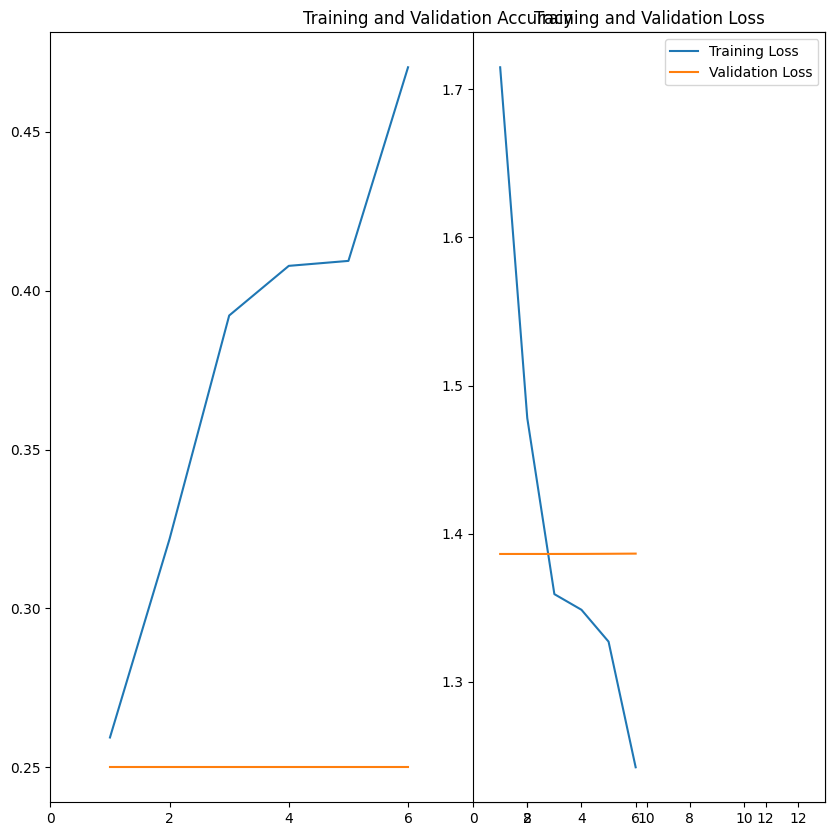

In [ ]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

**Confusion Matrix & Classification Report**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
                  precision    recall  f1-score   support

      bika ambon       0.00      0.00      0.00         9
     kerak telur       0.00      0.00      0.00        15
          papeda       0.00      0.00      0.00        10
plecing kangkung       0.29      1.00      0.45        14

        accuracy                           0.29        48
       macro avg       0.07      0.25      0.11        48
    weighted avg       0.09      0.29      0.13        48



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


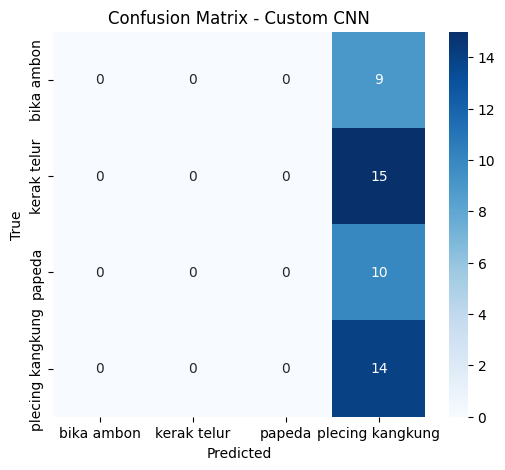

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

y_true = []
y_pred = []

for images, labels in test_ds:
    try:
        probs = model.predict(images)
        preds = np.argmax(probs, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    except tf.errors.InvalidArgumentError as e:
        print(f"Skipping batch due to error: {e}")
        continue


y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES_ORDER))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=CLASS_NAMES_ORDER,
            yticklabels=CLASS_NAMES_ORDER)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom CNN")
plt.show()

In [ ]:
import tensorflow as tf
import os

print("Checking image integrity in test dataset...")

# Assuming test_dir is defined and points to your test dataset directory
# You might need to adjust the path based on your setup

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                try:
                    # Attempt to decode the image
                    img = tf.io.read_file(image_path)
                    img = tf.image.decode_image(img, channels=3, expand_animations=False)
                    # Optional: Check image shape/size if needed
                    # img = tf.image.resize(img, IMG_SIZE)

                except tf.errors.Unsupported:
                    print(f"❌ Error: Could not decode image at {image_path} (Unsupported format or corrupted)")
                except Exception as e:
                    print(f"❌ Error processing image at {image_path}: {e}")

print("Image integrity check complete.")

In [ ]:
model.save("../models/BestModel_MobileNet_A_KERAS.h5")
print("✅ Model disimpan sebagai BestModel_CustomCNN_A_KERAS.h5")

✅ Model disimpan sebagai BestModel_CustomCNN_A_KERAS.h5
